In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, models, transforms

In [2]:
transform = transforms.Compose([transforms.RandomResizedCrop(224), transforms.ToTensor()])

train = datasets.ImageFolder('dataset/training_set/', transform = transform)
test = datasets.ImageFolder('dataset/test_set/', transform = transform)

In [3]:
train_dataloader = DataLoader(train, batch_size = 32, drop_last = True, shuffle = True)
test_dataloader = DataLoader(test, batch_size = 32, drop_last = True, shuffle = True)

In [17]:
train

Dataset ImageFolder
    Number of datapoints: 8000
    Root location: dataset/training_set/
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               ToTensor()
           )

In [5]:
next(iter(train_dataloader))[1].shape

torch.Size([32])

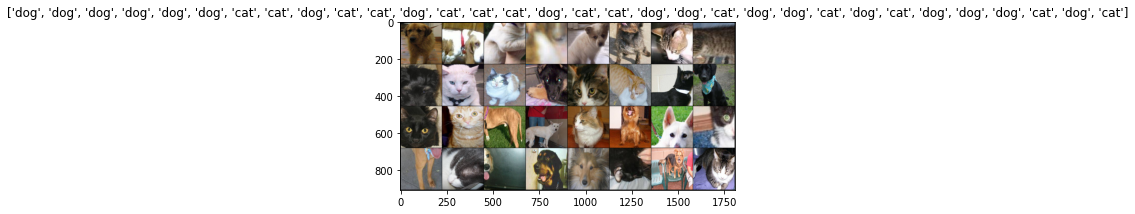

In [6]:
class_names = train.classes
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputx = next(iter(train_dataloader))
inputs, classes = inputx[0], inputx[1]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
# creating our custom neural network

class Net(nn.Module):
    '''This is the fundamental architecture of FCNN'''
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(150528, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 16)
        self.fc4 = nn.Linear(16, 1)
        self.sig = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = torch.flatten(x, 1) # flatten the image except the batch size
        x = self.sig(self.fc1(x))
        x = self.dropout(x)
        x = self.sig(self.fc2(x))
        x = self.dropout(x)
        x = self.sig(self.fc3(x))
        x = self.dropout(x)
        x = self.sig(self.fc4(x)) 
        return x
    

In [8]:
model = Net() # initializing the model


# Creating the loss function
# loss = nn.CrossEntropyLoss() # Muticlass classification 
criterion = nn.BCELoss() # Binary classification
# loss = nn.MSELoss() # loss function for regression

# Creating the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [9]:
# Initializing the device 
device = ('cuda' if torch.cuda.is_available() else 'cpu' )

# Creating the training loop

training_loss_epoch = []
testing_loss_epoch = []

# Best weights
best_weight = dict()

# Creating our epochs
epoch = 10

# Take our model to " GPU" or " CPU"
model.to(device)
criterion.to(device)

for epoch in range(epoch):
    
    print('\n')
    print(f'Starting training of epoch {epoch}')
    print('_' * 30)
    
    training_loss = 0
    testing_loss = 0
    
    model.train() # setting the model to training mode
    
    for images, labels in train_dataloader:
        
        images = images.type(torch.float)
        labels = labels.type(torch.float)
        
        # Taking the image and lables to device
        images.to(device)
        labels.to(device)
        
        # Zero down the gradients for each batch
        optimizer.zero_grad()
        
        # Passing the images to model
        # This is the forward pass 
        logits = model(images)
        labels = labels.unsqueeze(1)
        
        # Calculating the loss
        loss = criterion(logits, labels)
        
        # Applying the back propagation
        loss.backward()
        
        # Applying the gradient descent
        optimizer.step()
        
        # Adding the loss
        training_loss += loss
    
    
    model.eval() # Setting the model to evaluation mode
    
    total_corrects = []
    size = len(test_dataloader.dataset)
    
    with torch.no_grad():
        
        
        num_batches = size // test_dataloader.batch_size
        total_correct = 0
        
        for images, labels in test_dataloader:

            images = images.type(torch.float)
            labels = labels.type(torch.float)

            # Taking images and labels of test data to device
            images.to(device)
            labels.to(device)
            

            # Predicting the test image
            logits = model(images)
            labels = labels.unsqueeze(1)


            # Predicting the loss for test dataset
            test_loss = criterion(logits, labels)
            
            # Calculating the total accurate predictions each batch
            
            for i in range(test_dataloader.batch_size):
                if logits[i].item() >= 0.5 and labels[i].item() == 1:
                    total_correct += 1
                if logits[i].item() < 0.5 and labels[i].item() == 0:
                    total_correct += 1

            testing_loss += test_loss
        
        total_corrects.append(total_correct)

    training_loss_epoch.append(training_loss)
    testing_loss_epoch.append(testing_loss)
    
    
    print(f'Training loss is : {training_loss}')
    print(f'Testing loss is : {testing_loss}')
    print(f'Validation Accuracy : {total_corrects[-1] / size}')
    
    
    # if the loss of the test dataset is decreasing, we will save the model weights
    if epoch > 1:
        if testing_loss < min(testing_loss_epoch):
            best_weight = model.state_dict()



Starting training of epoch 0
______________________________
Training loss is : 173.83155822753906
Testing loss is : 42.97582244873047
Validation Accuracy : 0.4962518740629685


Starting training of epoch 1
______________________________
Training loss is : 173.60414123535156
Testing loss is : 42.97956848144531
Validation Accuracy : 0.495752123938031


Starting training of epoch 2
______________________________
Training loss is : 173.37286376953125
Testing loss is : 42.99127960205078
Validation Accuracy : 0.495752123938031


Starting training of epoch 3
______________________________
Training loss is : 173.38819885253906
Testing loss is : 42.97584533691406
Validation Accuracy : 0.495752123938031


Starting training of epoch 4
______________________________
Training loss is : 173.3502960205078
Testing loss is : 42.97669219970703
Validation Accuracy : 0.495752123938031


Starting training of epoch 5
______________________________
Training loss is : 173.3152313232422
Testing loss is : 42.

In [45]:
test_dataloader.batch_size

32

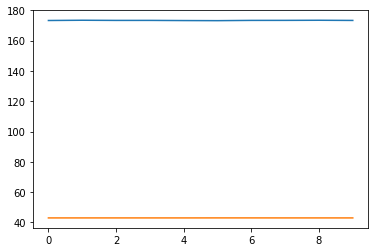

In [57]:
epoch = list(range(10))
train_loss = []
val_loss = []

for i in training_loss_epoch:
    train_loss.append(i.item())
    
train_loss = train_loss[::2]

for i in testing_loss_epoch:
    val_loss.append(i.item())
    
val_loss = val_loss[::2]


import matplotlib.pyplot as plt
plt.plot(epoch, train_loss)
plt.plot(epoch, val_loss)

In [55]:
training_loss_epoch

[tensor(173.3090, grad_fn=<AddBackward0>),
 tensor(173.3090, grad_fn=<AddBackward0>),
 tensor(173.4780, grad_fn=<AddBackward0>),
 tensor(173.4780, grad_fn=<AddBackward0>),
 tensor(173.3707, grad_fn=<AddBackward0>),
 tensor(173.3707, grad_fn=<AddBackward0>),
 tensor(173.3785, grad_fn=<AddBackward0>),
 tensor(173.3785, grad_fn=<AddBackward0>),
 tensor(173.2706, grad_fn=<AddBackward0>),
 tensor(173.2706, grad_fn=<AddBackward0>),
 tensor(173.2038, grad_fn=<AddBackward0>),
 tensor(173.2038, grad_fn=<AddBackward0>),
 tensor(173.3775, grad_fn=<AddBackward0>),
 tensor(173.3775, grad_fn=<AddBackward0>),
 tensor(173.3955, grad_fn=<AddBackward0>),
 tensor(173.3955, grad_fn=<AddBackward0>),
 tensor(173.4675, grad_fn=<AddBackward0>),
 tensor(173.4675, grad_fn=<AddBackward0>),
 tensor(173.3524, grad_fn=<AddBackward0>),
 tensor(173.3524, grad_fn=<AddBackward0>)]